## Define Area of Interest (AOI)

Use the map below to draw a rectangle defining your processing area. The maximum size is approximately 600x600 pixels at 10m resolution.

In [1]:
import openeo
from pathlib import Path
import config
from geospatial_pipeline.udp_generator import create_classification_cube, generate_udp


In [ ]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu/")
connection.authenticate_oidc()
UDPdir = Path('C:/Git_projects/WAC/classification/UDP/')

generate_udp(conn=connection,
    build_pipeline_fn = create_classification_cube,  # <-- pass function, not result
    process_id =  'WAC_inference_asia',
    summary = 'WAC_inference_asia',
    output_dir = UDPdir)

Authenticated using refresh token.
Saved UDP JSON to C:\Git_projects\WAC\classification\UDP\WAC_inference_asia.json


{'process_graph': {'loadcollection1': {'process_id': 'load_collection',
   'arguments': {'bands': ['B02',
     'B03',
     'B04',
     'B05',
     'B06',
     'B07',
     'B08',
     'B11',
     'B12'],
    'id': 'SENTINEL2_L2A',
    'properties': {'eo:cloud_cover': {'process_graph': {'lte1': {'process_id': 'lte',
        'arguments': {'x': {'from_parameter': 'value'}, 'y': 85},
        'result': True}}}},
    'spatial_extent': {'west': 300000,
     'south': 9800000,
     'east': 305000,
     'north': 9805000,
     'crs': 'EPSG:3035'},
    'temporal_extent': ['2023-06-01', '2023-08-01']}},
  'resamplespatial1': {'process_id': 'resample_spatial',
   'arguments': {'align': 'upper-left',
    'data': {'from_node': 'loadcollection1'},
    'method': 'near',
    'projection': 'EPSG:3035',
    'resolution': 10}},
  'loadcollection2': {'process_id': 'load_collection',
   'arguments': {'bands': ['SCL'],
    'id': 'SENTINEL2_L2A',
    'properties': {'eo:cloud_cover': {'process_graph': {'lte2': {'

In [ ]:
from geospatial_pipeline.input_cube_loader import load_input_cube
from geospatial_pipeline.onnx_inference import run_inference

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

cube = load_input_cube(
        connection,
        spatial_extent=config.SPATIAL_EXTENT,
        temporal_extent=config.TEMPORAL_EXTENT,
        max_cloud_cover=config.MAX_CLOUD_COVER,
        resolution=config.RESOLUTION,
        crs=config.CRS
    )

# Run inference
inference_cube = run_inference(
    cube,
    model_name=config.MODEL_NAME,
    patch_size=config.PATCH_SIZE,
    overlap=config.OVERLAP_SIZE
)

# Rename bands to probability labels
class_labels = [f"prob_class_{c}" for c in range(config.N_CLASSES)] + ['classification']
inference_cube = inference_cube.rename_labels(dimension='bands', target=class_labels)
save_cube = save_cube.save_result(format = "netCDF")


job = connection.create_job(save_cube,
    additional=config.JOB_OPTIONS
)

job.start_and_wait()




Authenticated using refresh token.
0:00:00 Job 'j-2508081003584d82843317cf234911eb': send 'start'
0:00:13 Job 'j-2508081003584d82843317cf234911eb': queued (progress 0%)
0:00:18 Job 'j-2508081003584d82843317cf234911eb': queued (progress 0%)
0:00:25 Job 'j-2508081003584d82843317cf234911eb': queued (progress 0%)
0:00:33 Job 'j-2508081003584d82843317cf234911eb': queued (progress 0%)
0:00:43 Job 'j-2508081003584d82843317cf234911eb': queued (progress 0%)
0:00:55 Job 'j-2508081003584d82843317cf234911eb': queued (progress 0%)
0:01:10 Job 'j-2508081003584d82843317cf234911eb': queued (progress 0%)
0:01:30 Job 'j-2508081003584d82843317cf234911eb': running (progress N/A)
0:01:54 Job 'j-2508081003584d82843317cf234911eb': running (progress N/A)
0:02:24 Job 'j-2508081003584d82843317cf234911eb': running (progress N/A)
0:03:01 Job 'j-2508081003584d82843317cf234911eb': running (progress N/A)
0:03:48 Job 'j-2508081003584d82843317cf234911eb': running (progress N/A)
0:04:46 Job 'j-2508081003584d82843317cf2

<BatchJob job_id='j-2508081003584d82843317cf234911eb'>

In [15]:
OUTPUT_DIR = "C:\\Git_projects\\WAC\\classification\\" + job.job_id
OUTPUT_FILE_ROI = f"{OUTPUT_DIR}"
job.get_results().download_files(OUTPUT_FILE_ROI)


[WindowsPath('C:/Git_projects/WAC/classification/j-2508080955034c0a944e45cfbb208833/openEO.nc'),
 WindowsPath('C:/Git_projects/WAC/classification/j-2508080955034c0a944e45cfbb208833/job-results.json')]

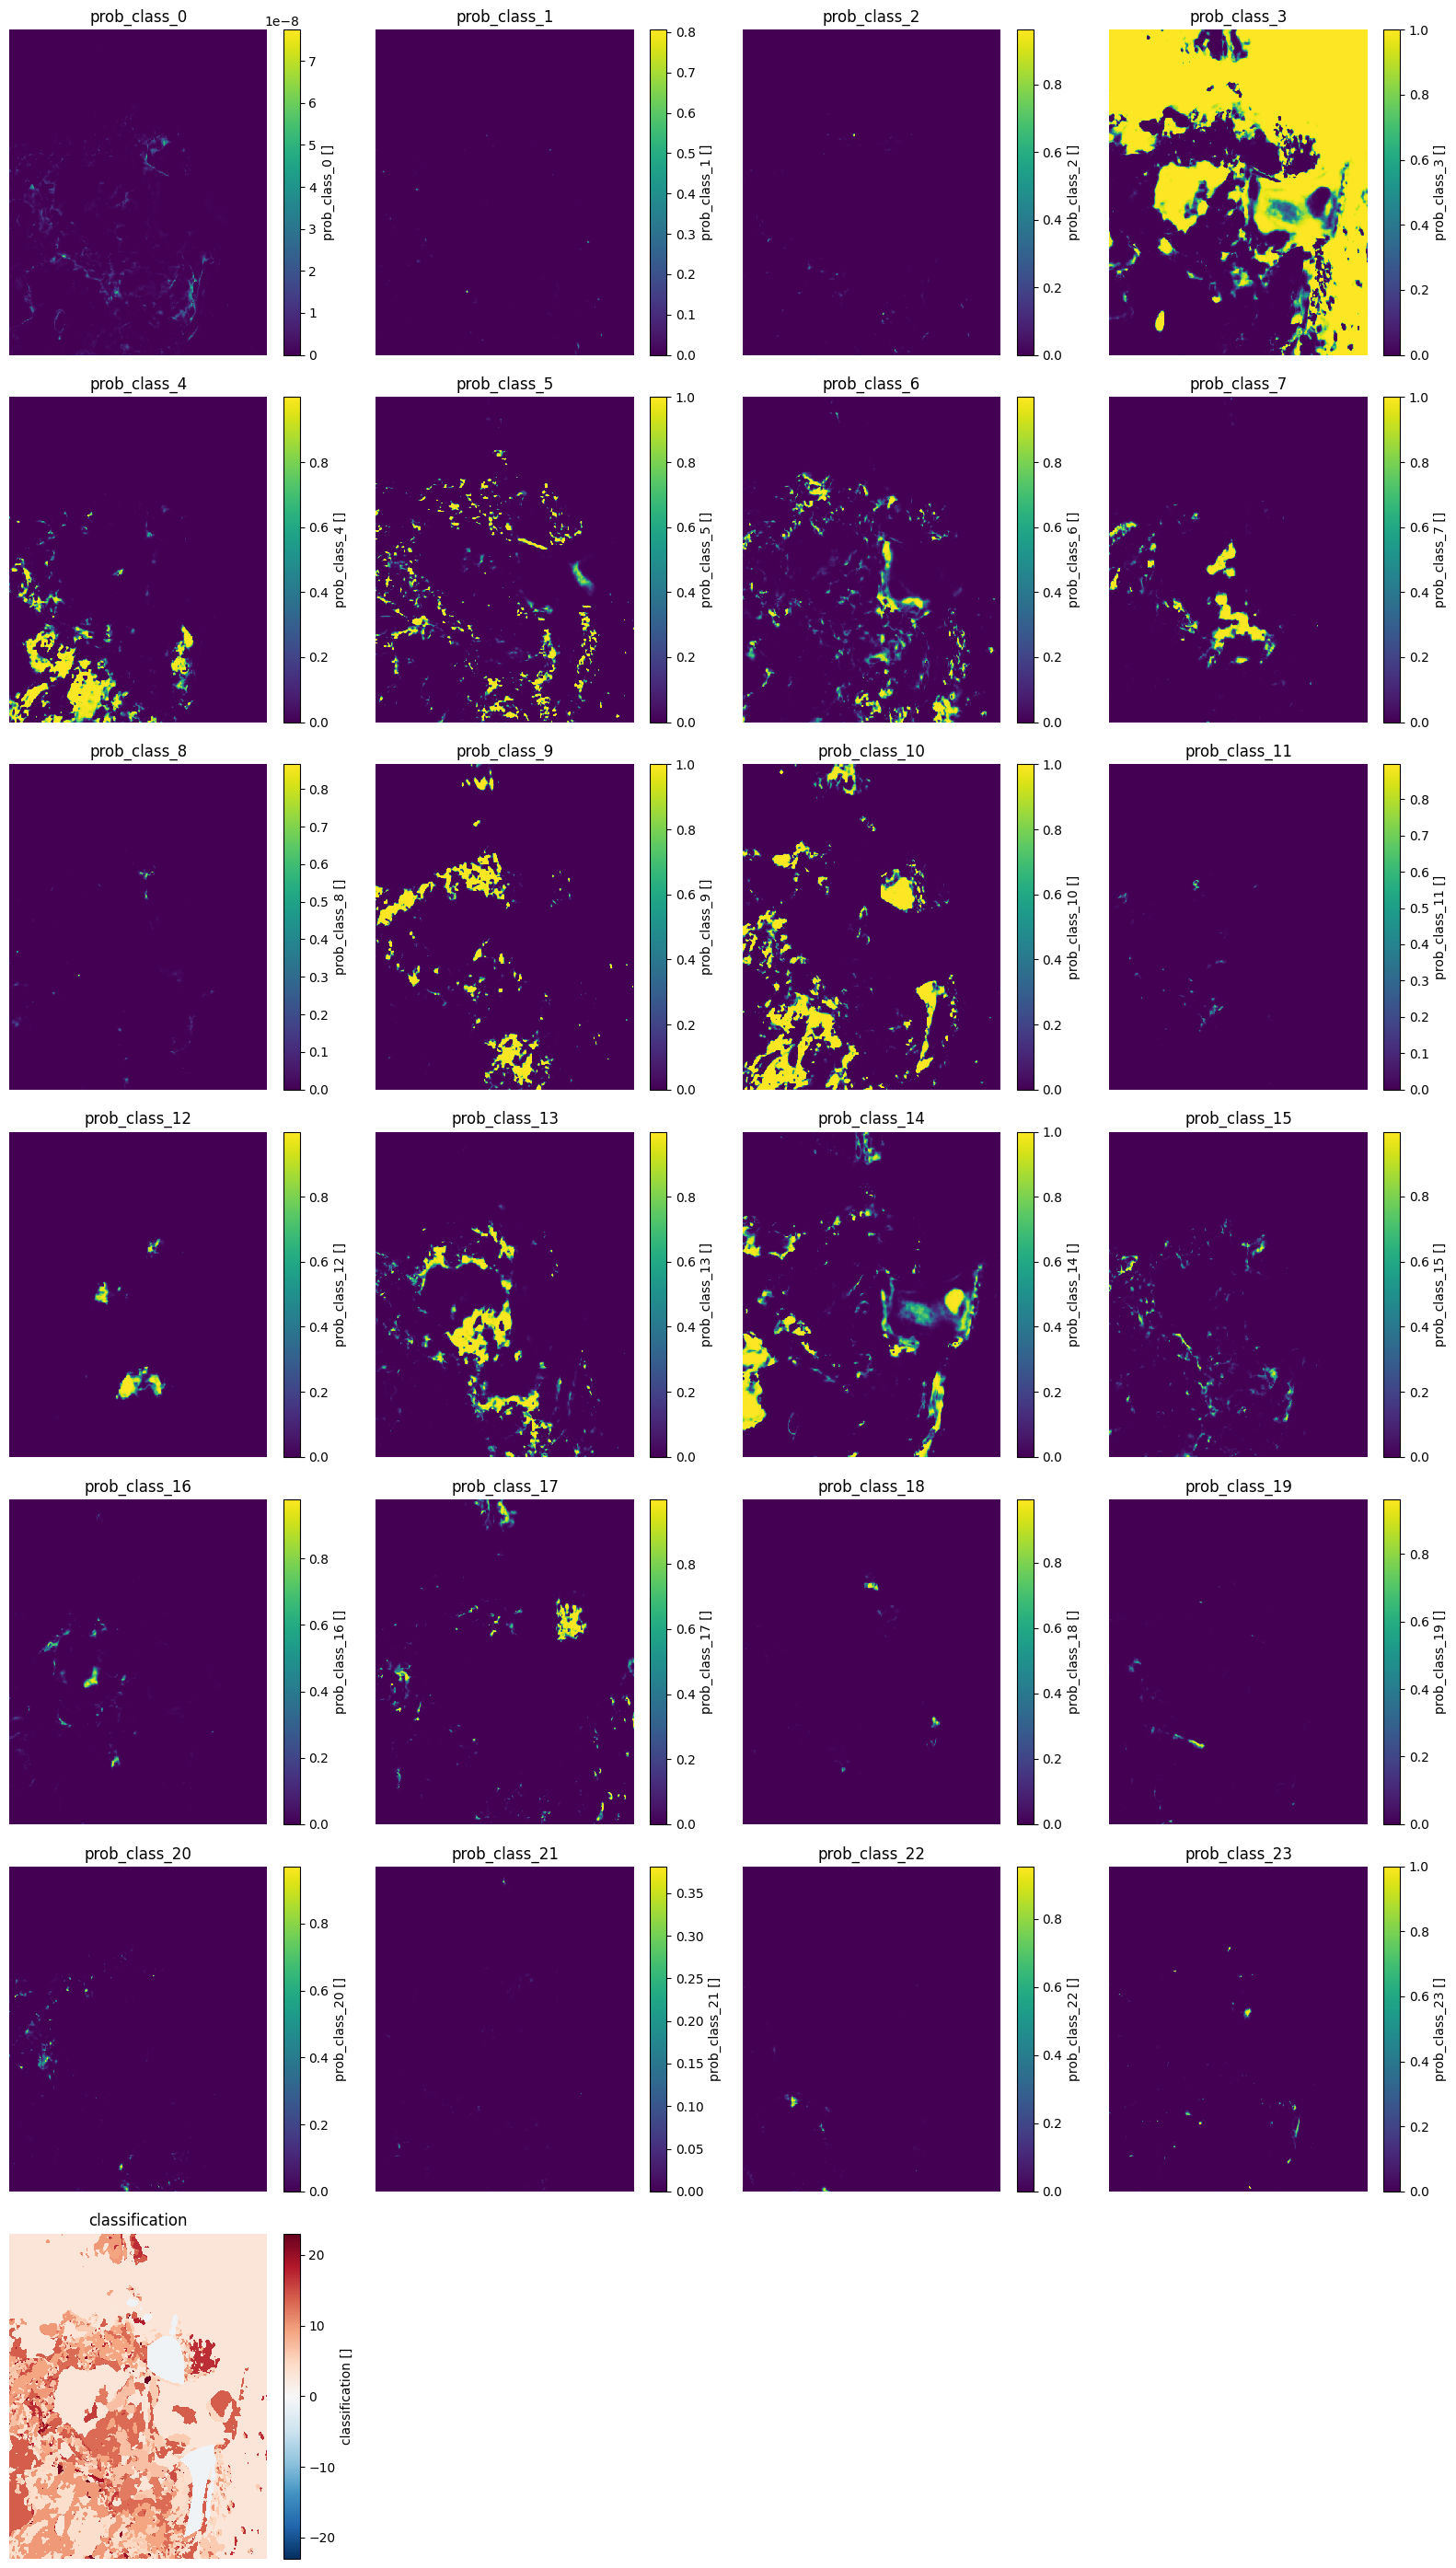

In [17]:


import matplotlib.pyplot as plt
import xarray as xr
# Load dataset
ds = xr.open_dataset("C:/Git_projects/WAC/classification/j-2508080955034c0a944e45cfbb208833/openEO.nc")

# Filter only variables with dimensions (t, y, x)
variables_to_plot = [var for var in ds.data_vars if {'t', 'y', 'x'}.issubset(ds[var].dims)]

n = len(variables_to_plot)
ncols = 4  # adjust based on how wide you want the figure
nrows = -(-n // ncols)  # ceiling division

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))

for i, var in enumerate(variables_to_plot):
    ax = axes.flat[i]
    ds[var].isel(t=0).plot(ax=ax, add_colorbar=True)
    ax.set_title(var)
    ax.axis('off')

# Hide any unused subplots
for j in range(i + 1, len(axes.flat)):
    axes.flat[j].axis('off')

plt.tight_layout()
plt.show()

